In [1]:
# Mengubah akses file kaggle kredential
! chmod 600 /content/kaggle.json

chmod: cannot access '/content/kaggle.json': No such file or directory


In [2]:
# Import dataset ke folder content
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d paultimothymooney/chest-xray-pneumonia/

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/versions/
License(s): other
100% 2.29G/2.29G [00:33<00:00, 161MB/s]
100% 2.29G/2.29G [00:33<00:00, 73.0MB/s]


In [3]:
# Melakukan ekstraksi pada file zip
import zipfile,os

zip_file = zipfile.ZipFile('/content/chest-xray-pneumonia.zip')
zip_file.extractall('/content')

In [4]:
# Membuat dan mendefinisikan variabel dataset
train_dir = '/content/chest_xray/train'
test_dir = '/content/chest_xray/test'
val_dir = '/content/chest_xray/val'

# Mengecek folder Batik
print(os.listdir(train_dir))
print(os.listdir(test_dir))
print(os.listdir(val_dir))

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


In [5]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(train_dir):
    counting = len(os.listdir(os.path.join(train_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files Dataset Gambar : " + str(total_files))

Total Files Dataset Gambar : 5216


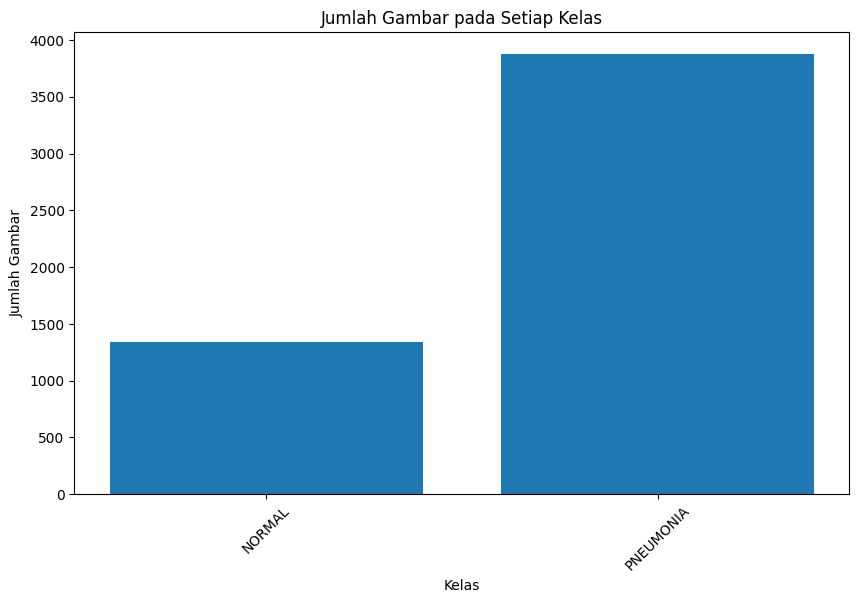

In [6]:
import os
import matplotlib.pyplot as plt

# Fungsi untuk menghitung jumlah gambar dalam setiap kelas
def count_images_in_folders(root_dir):
    class_counts = {}
    classes = os.listdir(root_dir)
    for class_name in classes:
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            image_names = os.listdir(class_dir)
            class_counts[class_name] = len(image_names)
    return class_counts

class_counts = count_images_in_folders(train_dir)

# Membuat diagram batang
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.title('Jumlah Gambar pada Setiap Kelas')
plt.xticks(rotation=45)
plt.show()

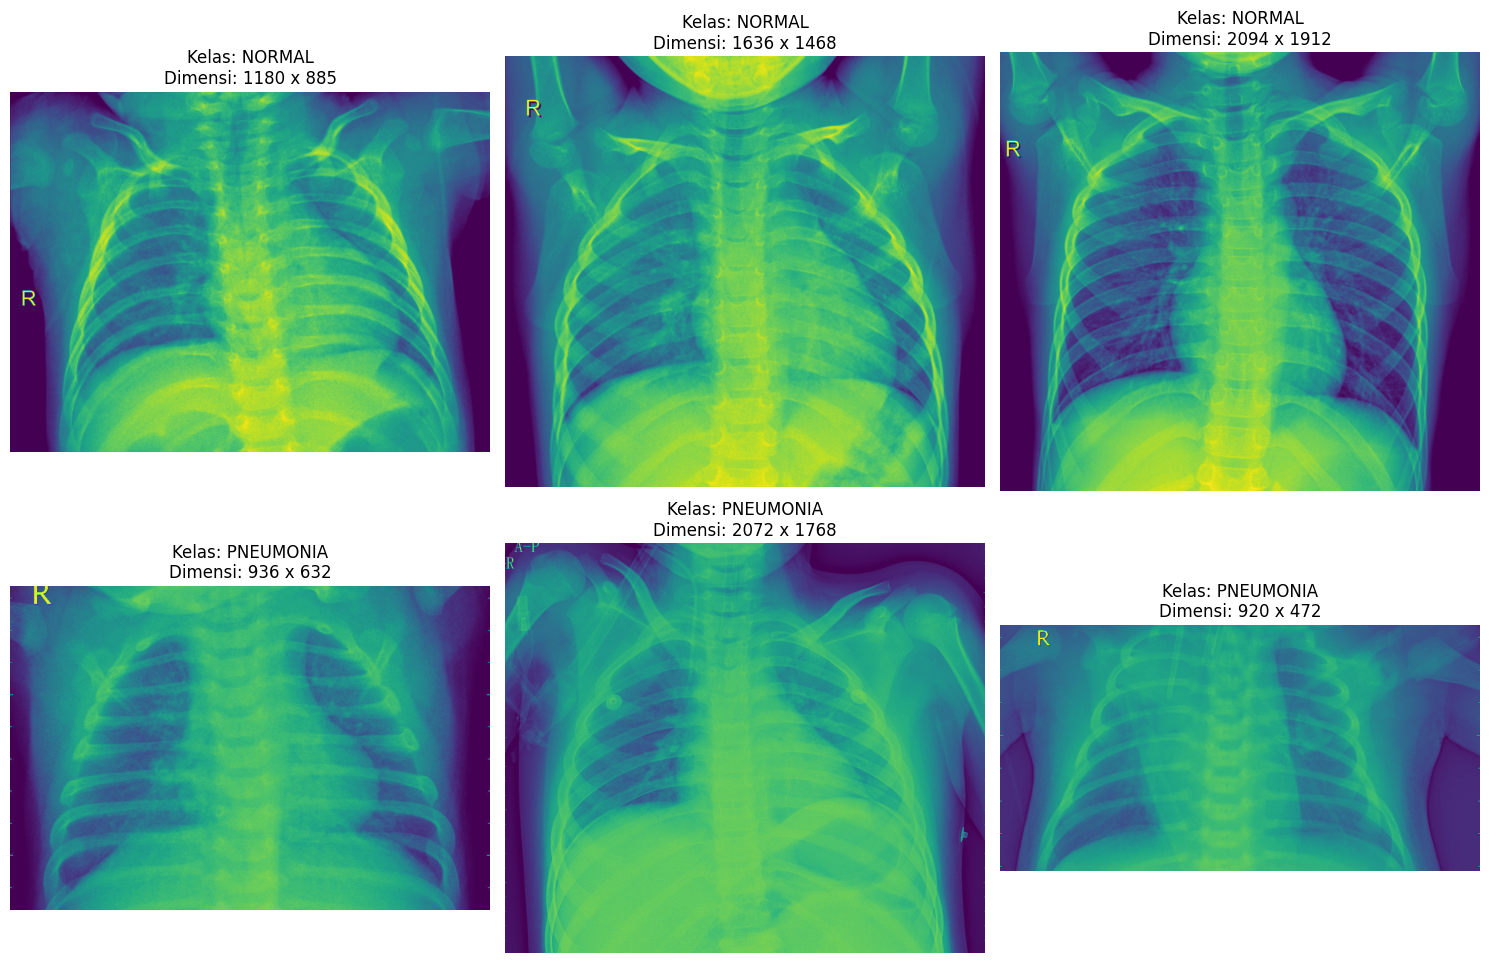

In [7]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Mengecek beberapa gambar saja per kelas
num_images_to_check = 3

# Membuat list untuk menyimpan informasi tentang dimensi gambar
image_info_list = []

# Ambil nama kelas dalam dataset
class_names = os.listdir(train_dir)

# Loop untuk memilih beberapa gambar dari setiap kelas
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        image_files = os.listdir(class_path)
        random.shuffle(image_files)  # Acak urutan gambar
        for image_file in image_files[:num_images_to_check]:
            image_path = os.path.join(class_path, image_file)
            image = Image.open(image_path)
            width, height = image.size
            image_info_list.append((class_name, image_path, width, height))

# Menampilkan informasi tentang beberapa gambar dari kelas yang berbeda
plt.figure(figsize=(15, 10))
for i, (class_name, image_path, width, height) in enumerate(image_info_list):
    plt.subplot(len(class_names), num_images_to_check, i + 1)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Kelas: {class_name}\nDimensi: {width} x {height}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# Pengaturan ukuran gambar
nb_batch_size = 32
nb_epochs = 10
img_height, img_width = 224, 224

# Augmentasi dan Rescale untuk data pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = 'nearest'
)

# Rescale saja untuk data pengujian dan validasi
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Pembagian data latih, data pengujian, dan data validasi
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=nb_batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=nb_batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=nb_batch_size,
    class_mode='categorical',
    shuffle=False  # Hindari perubahan urutan untuk evaluasi akhir
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
print("Jumlah Data Validation :", validation_generator.class_indices)
print("Panjang Data Validation :", len(validation_generator.class_indices))

Jumlah Data Validation : {'NORMAL': 0, 'PNEUMONIA': 1}
Panjang Data Validation : 2


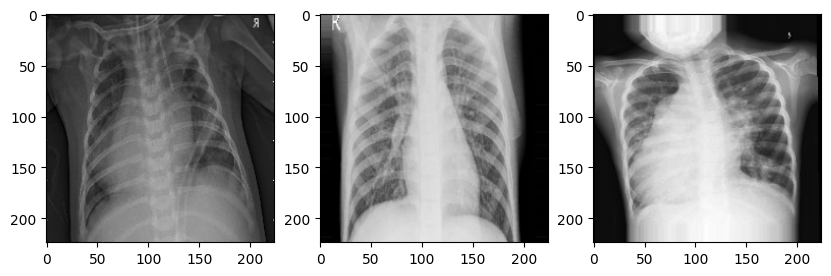

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
import os
import matplotlib.pyplot as plt

# Tentukan path direktori data latih
data_latih_dir = '/content/chest_xray/train'

# Menampilkan beberapa hasil augmentasi dari data train
jumlah_sampel_augmentasi = 3
plt.figure(figsize=(10, 16))
for i in range(jumlah_sampel_augmentasi):
    batch = train_generator.next()
    img = array_to_img(batch[0][0])
    plt.subplot(3, 3, i+1)
    plt.imshow(img)

plt.show()

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Muat model InceptionV3 terlatih (tidak termasuk lapisan atas)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Bekukan layer model dasar
for layer in base_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [13]:
# Tambah lapisan atas khusus untuk klasifikasi
x = base_model.output
x = keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.25)(x)

jumlah_kelas = len(validation_generator.class_indices)
predictions = keras.layers.Dense(jumlah_kelas, activation='softmax')(x)

# model akhir
model = keras.models.Model(inputs=base_model.input, outputs=predictions)

In [14]:
# Tampilkan ringkasan model
model.summary()

# Tampilkan input shape pada layer pertama
print("Input shape pada layer pertama: ", model.layers[0].input_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [15]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
from keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.90:
            print("\nReached 90% accuracy, stopping training!")
            self.model.stop_training = True

In [17]:
# hapus cache keras
tf.keras.backend.clear_session()

# train the model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = nb_epochs,
    callbacks=[CustomCallback()]
)

Epoch 1/10
163/163 [==============================] - 657s 4s/step - loss: 0.2693 - accuracy: 0.8892 - val_loss: 0.4233 - val_accuracy: 0.9375
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9254
Reached 90% accuracy, stopping training!
163/163 [==============================] - 639s 4s/step - loss: 0.1870 - accuracy: 0.9254 - val_loss: 0.3954 - val_accuracy: 0.9375


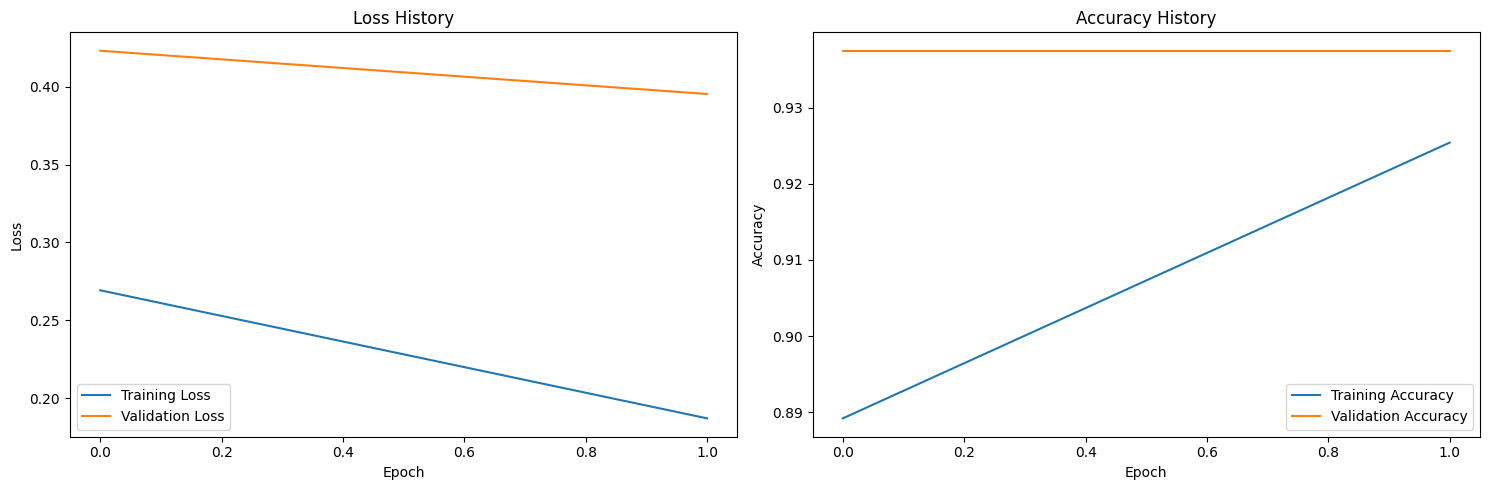

In [18]:
import matplotlib.pyplot as plt

# Misalkan history adalah hasil dari training model
# history = {'loss': [0.1, 0.08, 0.06, 0.05], 'val_loss': [0.09, 0.07, 0.06, 0.04],
#            'accuracy': [0.9, 0.92, 0.93, 0.94], 'val_accuracy': [0.91, 0.93, 0.94, 0.95]}

# Temukan epoch terbaik untuk loss validasi dan akurasi validasi
# best_epoch_val_loss = history.history['val_loss'].index(min(history.history['val_loss']))
# best_epoch_val_accuracy = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

# Plot Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.scatter(best_epoch_val_loss, history.history['val_loss'][best_epoch_val_loss], color='red', zorder=5)
# plt.annotate(f'Best epoch: {best_epoch_val_loss+1}', xy=(best_epoch_val_loss, history.history['val_loss'][best_epoch_val_loss]),
#              xytext=(best_epoch_val_loss, history.history['val_loss'][best_epoch_val_loss]+0.02),
#              arrowprops=dict(facecolor='black', shrink=0.05))
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.scatter(best_epoch_val_accuracy, history.history['val_accuracy'][best_epoch_val_accuracy], color='red', zorder=5)
# plt.annotate(f'Best epoch: {best_epoch_val_accuracy+1}', xy=(best_epoch_val_accuracy, history.history['val_accuracy'][best_epoch_val_accuracy]),
#              xytext=(best_epoch_val_accuracy, history.history['val_accuracy'][best_epoch_val_accuracy]-0.05),
#              arrowprops=dict(facecolor='black', shrink=0.05))
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
skill = model.evaluate(test_generator)

20/20 [==============================] - 74s 4s/step - loss: 0.3752 - accuracy: 0.8510


In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [21]:
# Evaluasi model pada data pengujian dan hitung confusion matrix
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

20/20 [==============================] - 74s 4s/step


In [22]:
# Menampilkan daftar kelas atau label gambar
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [23]:
import pandas as pd

# Membuat tabel confusion matrix
class_names = list(test_generator.class_indices.keys())
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Menampilkan tabel confusion matrix
print(cm_df)

           NORMAL  PNEUMONIA
NORMAL        155         79
PNEUMONIA      14        376


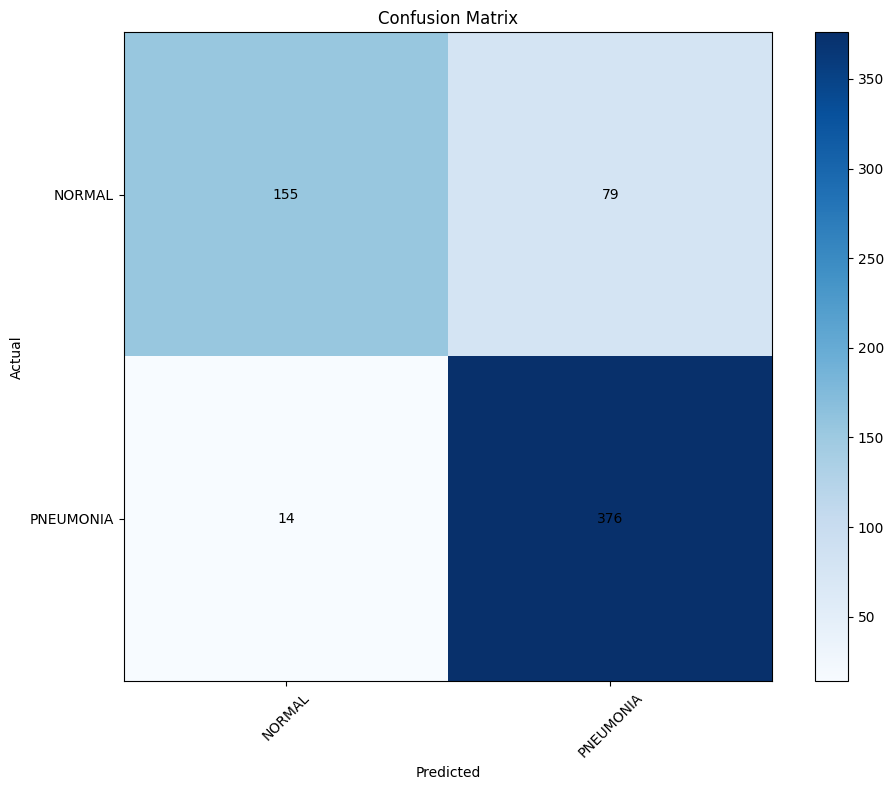

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already defined `cm_df` and `class_names` as shown in your code

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm_df, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations for each cell in the confusion matrix
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(cm_df.iloc[i, j]), horizontalalignment="center", verticalalignment="center")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluasi model pada data pengujian dan hitung confusion matrix
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Menghitung dan menampilkan laporan klasifikasi
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Menampilkan hasil evaluasi
print(report)


20/20 [==============================] - 72s 4s/step
              precision    recall  f1-score   support

      NORMAL       0.92      0.66      0.77       234
   PNEUMONIA       0.83      0.96      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.81      0.83       624
weighted avg       0.86      0.85      0.84       624



In [26]:
model.save('/content/drive/MyDrive/model_XRay.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
# Import library yang diperlukan
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
import numpy as np

# Load model dari file h5 dengan input_shape yang sesuai
model_path = '/content/drive/MyDrive/model_XRay.h5'
model = load_model(model_path, compile=False)

# Fungsi untuk memprediksi gambar
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(img_height, img_width))  # Resize gambar sesuai dengan img_height & img_width
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array)
    class_index = np.argmax(preds[0])  # Dapatkan indeks kelas dengan nilai prediksi tertinggi
    class_label = get_class_label(class_index)  # Ganti indeks kelas menjadi label kelas

    print("Hasil prediksi:", class_label)

# Fungsi untuk mengonversi indeks kelas menjadi label kelas (misalnya: 0 -> 'kelas_1', 1 -> 'kelas_2', dst.)
def get_class_label(index):
    # Ganti dengan label kelas sesuai dengan indeks kelas
    class_labels = ['NORMAL', 'PNEUMONIA']
    return class_labels[index]

# Masukkan path dari gambar yang ingin Anda prediksi
image_path = '/content/chest_xray/test/NORMAL/IM-0027-0001.jpeg'
predict_image(image_path)


1/1 [==============================] - 2s 2s/step
Hasil prediksi: NORMAL


1/1 [==============================] - 2s 2s/step


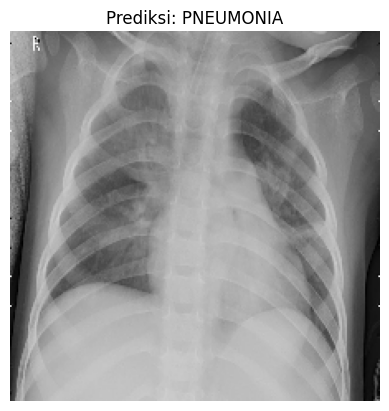

In [28]:
# Import library yang diperlukan
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt

# Load model dari file h5 dengan input_shape yang sesuai
model_path = '/content/drive/MyDrive/model_XRay.h5'
model = load_model(model_path, compile=False)

# Fungsi untuk memprediksi gambar
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(img_height, img_width))  # Resize gambar sesuai dengan img_height & img_width
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array)
    class_index = np.argmax(preds[0])  # Dapatkan indeks kelas dengan nilai prediksi tertinggi
    class_label = get_class_label(class_index)  # Ganti indeks kelas menjadi label kelas

    # Menampilkan gambar yang diprediksi
    plt.imshow(img)
    plt.title(f"Prediksi: {class_label}")
    plt.axis('off')
    plt.show()

# Fungsi untuk mengonversi indeks kelas menjadi label kelas (misalnya: 0 -> 'kelas_1', 1 -> 'kelas_2', dst.)
def get_class_label(index):
    # Ganti dengan label kelas sesuai dengan indeks kelas
    class_labels = ['NORMAL', 'PNEUMONIA']
    return class_labels[index]

# Masukkan path dari gambar yang ingin Anda prediksi
image_path = '/content/chest_xray/test/PNEUMONIA/person134_bacteria_643.jpeg'
predict_image(image_path)
